# Group 20 — Exploratory Data Analysis
This notebook performs an initial exploratory data analysis (EDA) on the provided customer and flights databases.
The goals are:
- Inspect imports and data quality
- Identify missing or strange values
- Preprocess data for downstream modeling

## Table of contents
- [Import data](#import-data)
- [Data Exploration](#data-exploration)
  - [Customer DB](#customer-db)
    - [Inspect import](#inspect-import-customer)
    - [Check categorical values](#check-cat-values-customer)
    - [Check Outliers](#check-outliers)
  - [Flights DB](#flights-db)
    - [Inspect import](#inspect-import-flights)
    - [Check Outliers](#check-outliers-flight)
- [Preprocessing](#preprocessing)
  - [Missing Values](#missing-values)
  - [Convert data types](#convert-data-types)

# <a id="import-data"></a> Import data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Load the data

customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 ).set_index("Loyalty#")
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv",  index_col="Loyalty#")


# <a id="data-exploration"></a> Data Exploration

### <a id="customer-db"></a> Customer DB

#### <a id="inspect-import-customer"></a> Inspect import

In [7]:
customer_db.head()

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


In [8]:
customer_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16921 entries, 480934 to 100016
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   First Name               16921 non-null  object 
 1   Last Name                16921 non-null  object 
 2   Customer Name            16921 non-null  object 
 3   Country                  16921 non-null  object 
 4   Province or State        16921 non-null  object 
 5   City                     16921 non-null  object 
 6   Latitude                 16921 non-null  float64
 7   Longitude                16921 non-null  float64
 8   Postal code              16921 non-null  object 
 9   Gender                   16921 non-null  object 
 10  Education                16921 non-null  object 
 11  Location Code            16921 non-null  object 
 12  Income                   16901 non-null  float64
 13  Marital Status           16921 non-null  object 
 14  LoyaltyStatus        

#### <a id="check-cat-values-customer"></a> Check categorical values

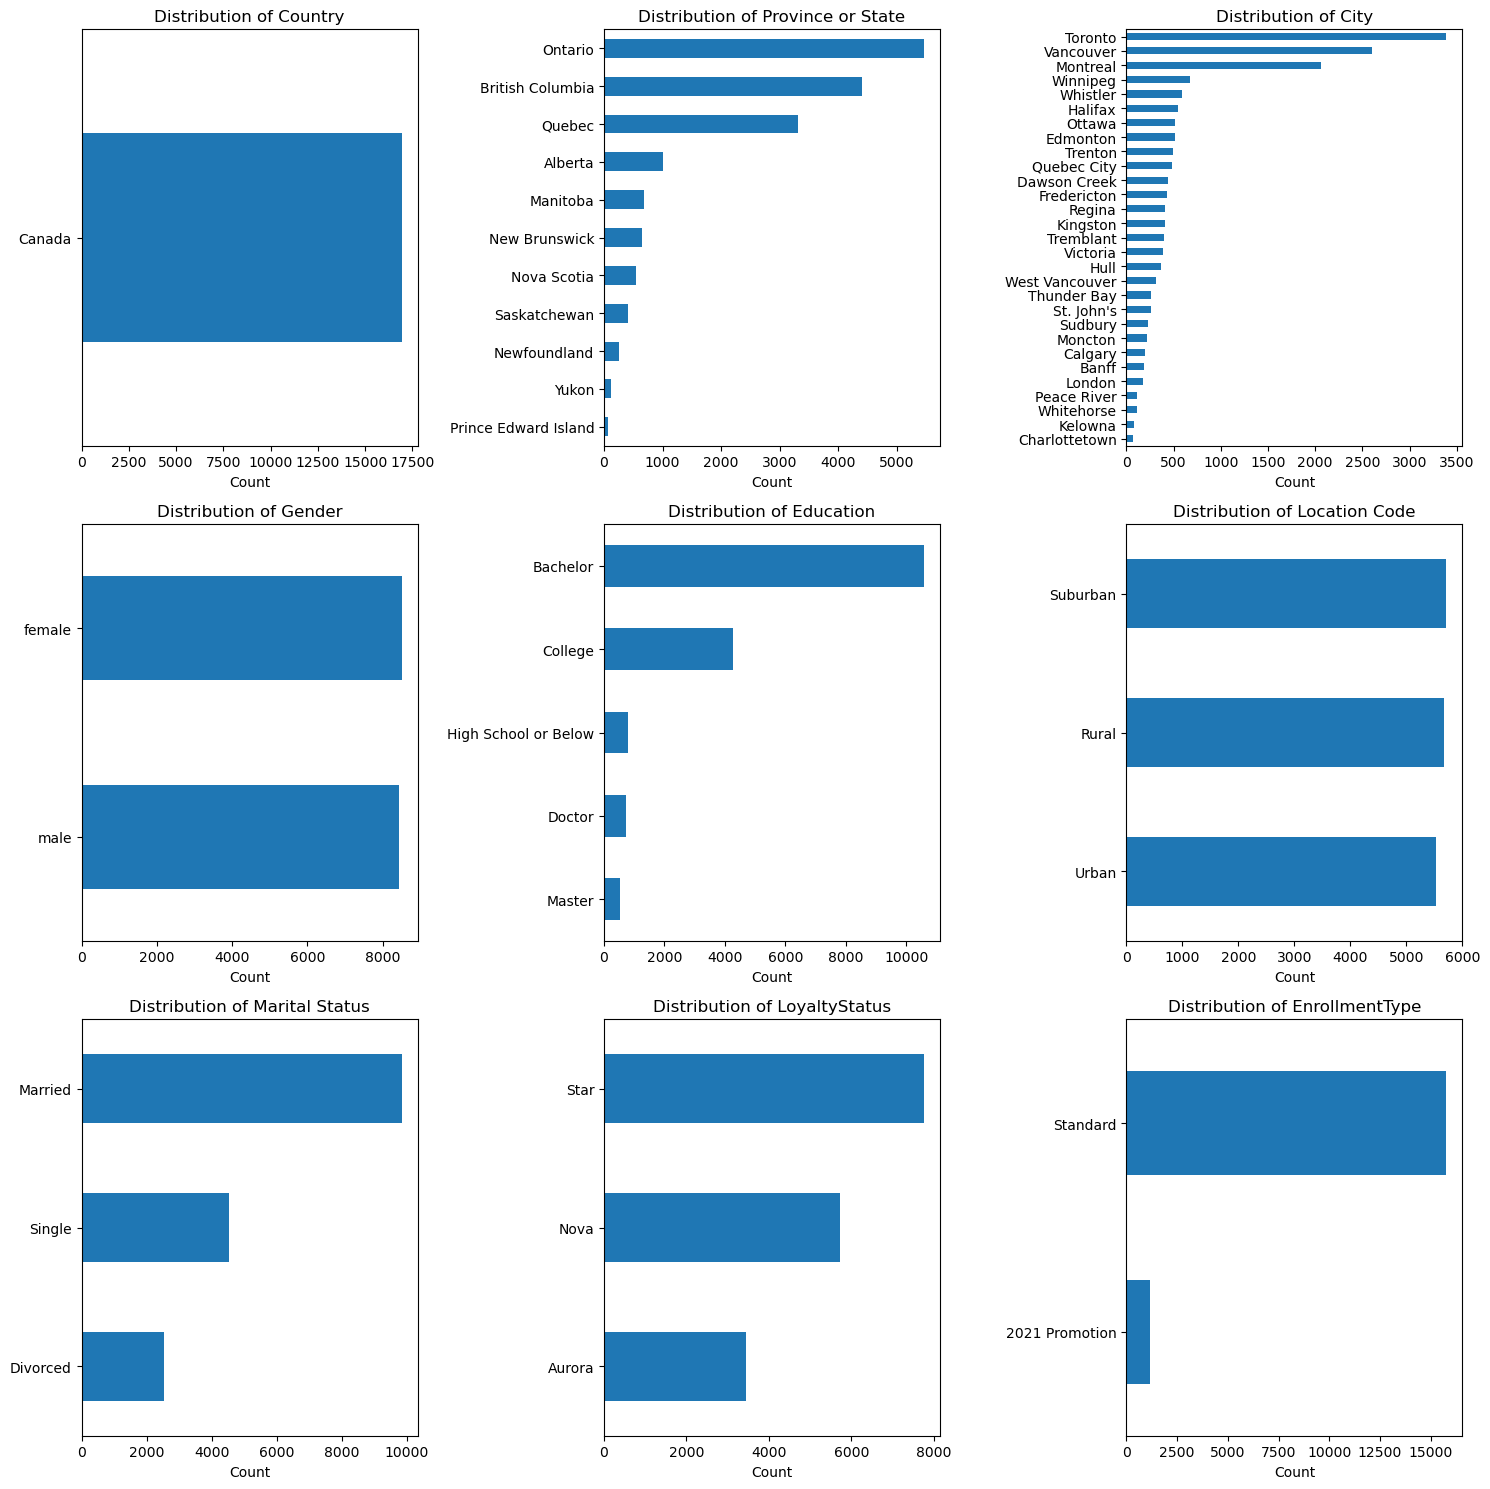

In [9]:
categorical_cols = [
    'Country', 'Province or State', 'City', 'Gender', 'Education',
    'Location Code', 'Marital Status', 'LoyaltyStatus', 'EnrollmentType'
]

# Create the figure and axes
fig, axes = plt.subplots(
    nrows=math.ceil(len(categorical_cols) / 3),
    ncols=3,
    figsize=(15, 15)
)

# Generate a plot for each categorical column
for ax, col in zip(axes.flatten(), categorical_cols):
    customer_db[col].value_counts().plot(
        kind='barh',
        ax=ax,
        title=f'Distribution of {col}'
    )
    ax.set_xlabel("Count")
    ax.set_ylabel("")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

### <a id="check-outliers"></a> Check Outliers

In [10]:

numeric_features = ["Income", "Customer Lifetime Value"]


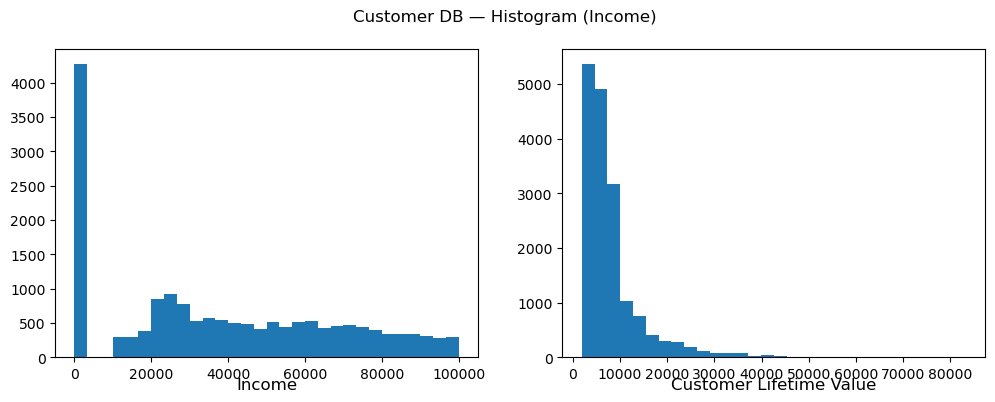

In [11]:
#checking the histogram of income and customer lifetime value
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat in zip(np.atleast_1d(axes).flatten(), numeric_features):
    ax.hist(customer_db[feat].dropna(), bins=30)
    ax.set_title(feat, y=-0.13)

plt.suptitle("Customer DB — Histogram (Income)")
plt.show()

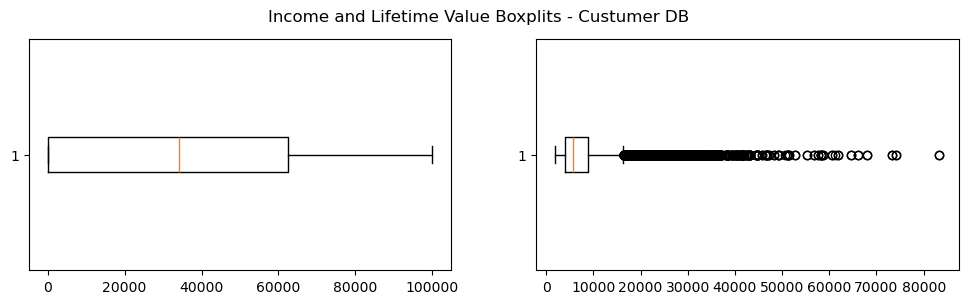

In [ ]:
#checking boxplot for income and customer lifetime value
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

for ax, feat in zip(np.atleast_1d(axes).ravel(), numeric_features):
    ax.boxplot(customer_db[feat].dropna().values, vert=False)

plt.suptitle("Income and Lifetime Value Boxplots - Customer DB")
plt.show()

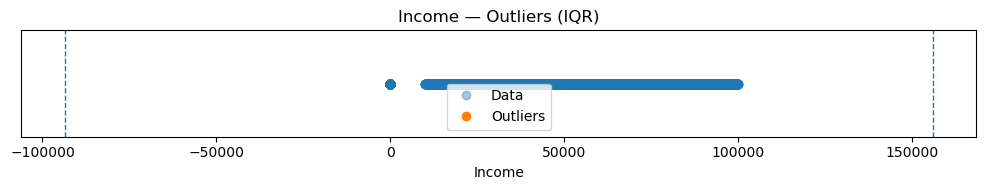

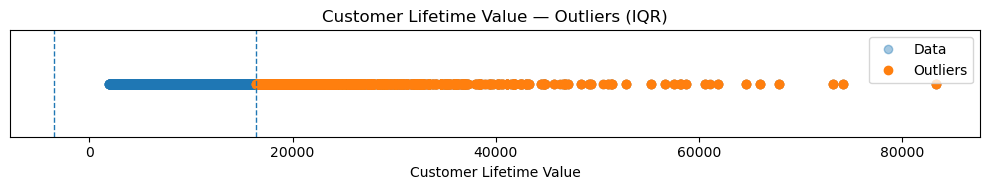

In [13]:
# Simple Outlier Visualization (IQR)


for feat in numeric_features:
    col_data  = customer_db[feat].dropna()

    # Q1 and Q3 quartiles
    q1 = col_data .quantile(0.25)
    q3 = col_data .quantile(0.75)
    iqr = q3 - q1

    # floor and ceiling for outliers
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    # indetifies the outliers
    outliers = col_data [(col_data  < low) | (col_data  > high)]

    # plot
    plt.figure(figsize=(10, 2))
    plt.plot(col_data , [0]*len(col_data ), 'o', alpha=0.4, label='Data')
    plt.plot(outliers, [0]*len(outliers), 'o', label='Outliers')

    # limits of x axis
    plt.axvline(low, linestyle='--', linewidth=1)
    plt.axvline(high, linestyle='--', linewidth=1)

    plt.title(feat + " — Outliers (IQR)")
    plt.yticks([])
    plt.xlabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

### <a id="flights-db"></a> Flights DB

#### <a id="inspect-import-flights"></a> Inspect import

In [14]:
flights_db.head()

,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
Loyalty#,,,,,,,,,
413052,2021,12,12/1/2021,2.0,2.0,9384.0,938.0,0.0,0.0
464105,2021,12,12/1/2021,0.0,0.0,0.0,0.0,0.0,0.0
681785,2021,12,12/1/2021,10.0,3.0,14745.0,1474.0,0.0,0.0
185013,2021,12,12/1/2021,16.0,4.0,26311.0,2631.0,3213.0,32.0
216596,2021,12,12/1/2021,9.0,0.0,19275.0,1927.0,0.0,0.0


In [27]:
flights_db.shape

(608436, 9)

### <a id="check-outliers-flight"></a> Check Outliers

In [15]:
numeric_features = [
    "NumFlights",
    "NumFlightsWithCompanions",
    "DistanceKM",
    "PointsAccumulated",
    "PointsRedeemed",
    "DollarCostPointsRedeemed"
]


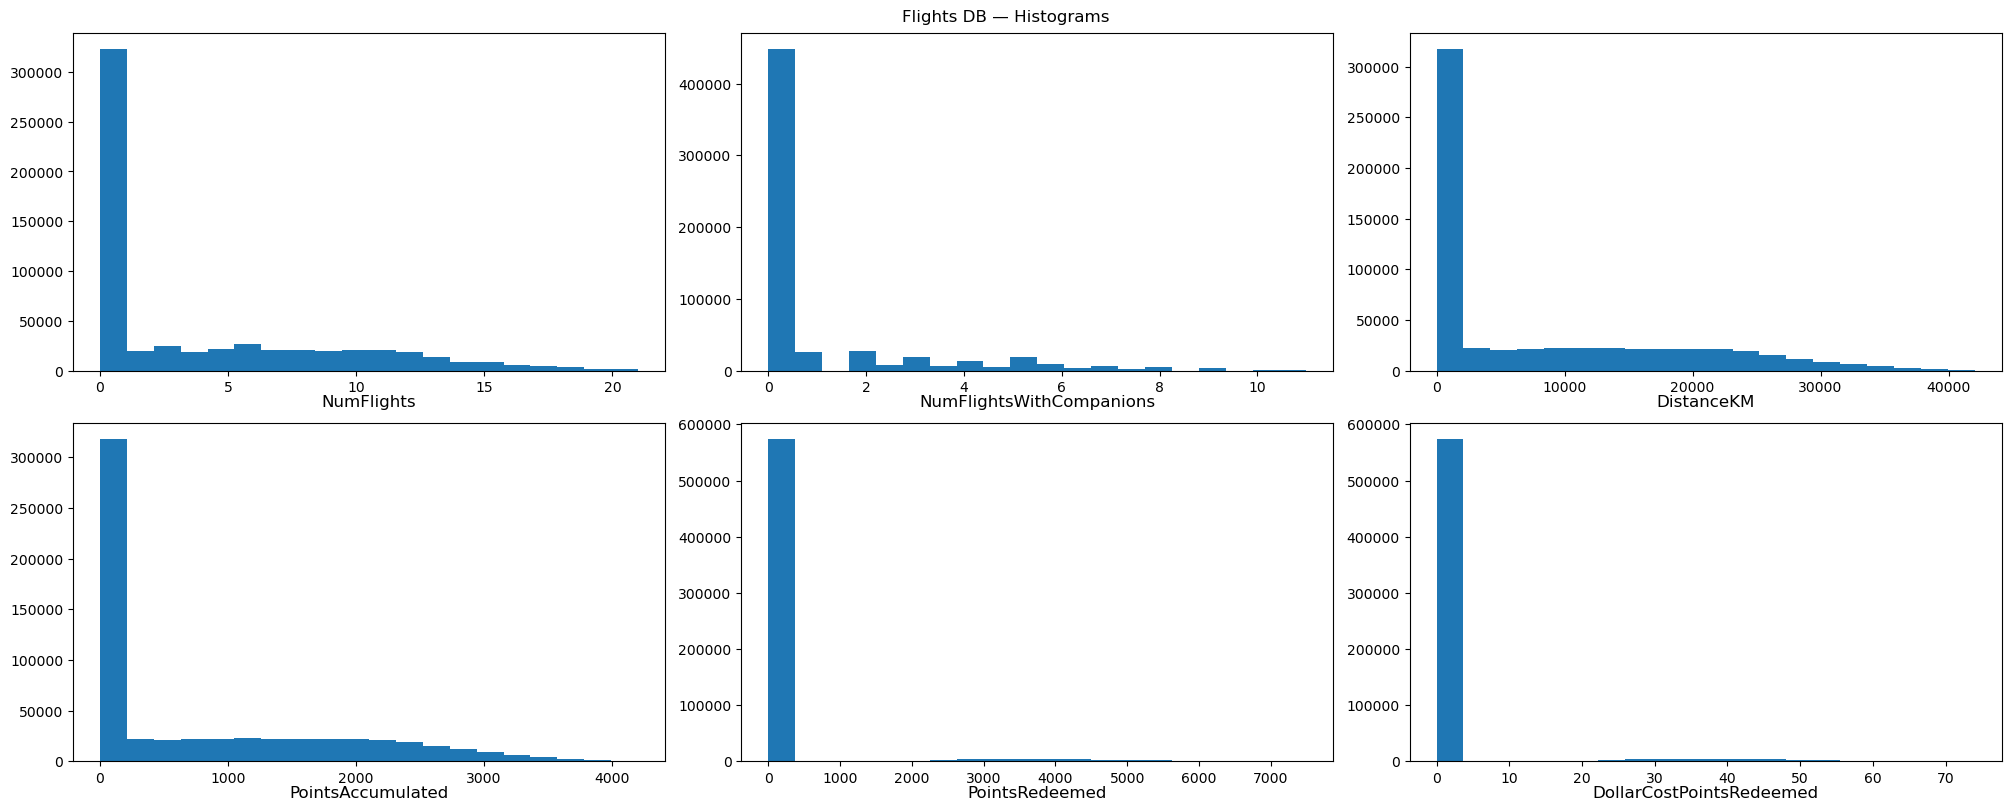

In [16]:

fig, axes = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True)

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(flights_db[feat].dropna(), bins=20)
    ax.set_title(feat, y=-0.13)

plt.suptitle("Flights DB — Histograms")
plt.show()

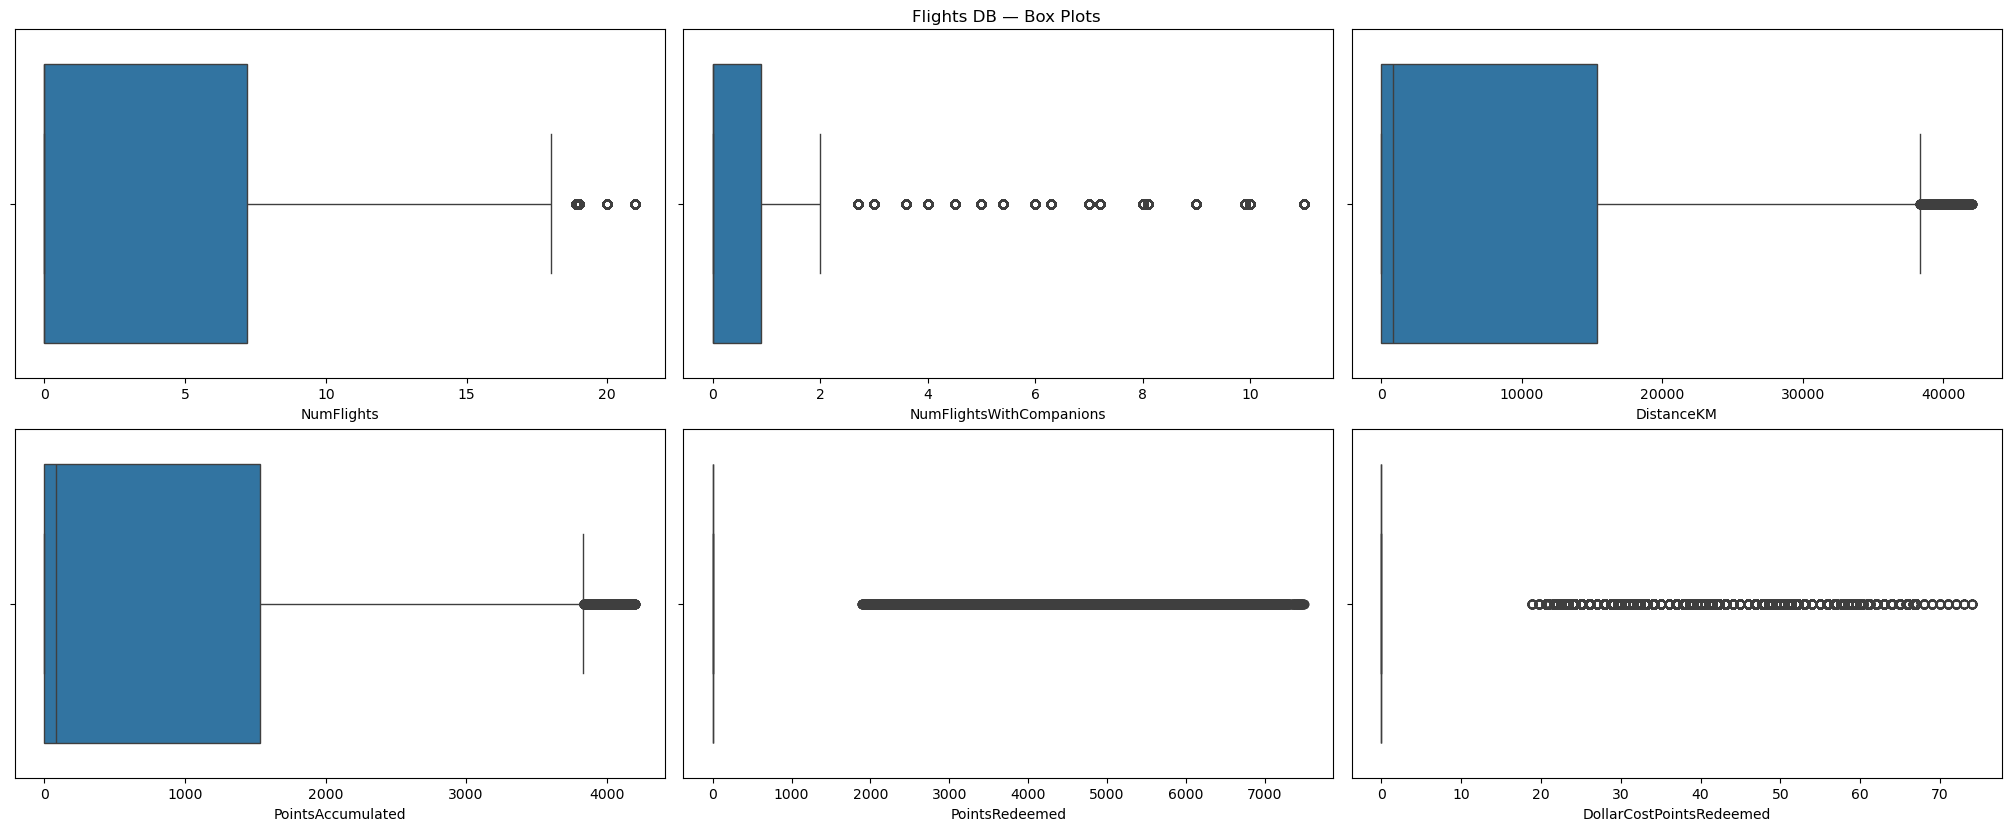

In [17]:
#checking boxplot 
fig, axes = plt.subplots(2, 3,figsize=(20, 8), constrained_layout=True)

for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(data=flights_db, x=feat, ax=ax)
    ax.set_xlabel(feat)                           
    ax.set_ylabel('')        

fig.suptitle("Flights DB — Box Plots", y=1.02)
plt.show() 

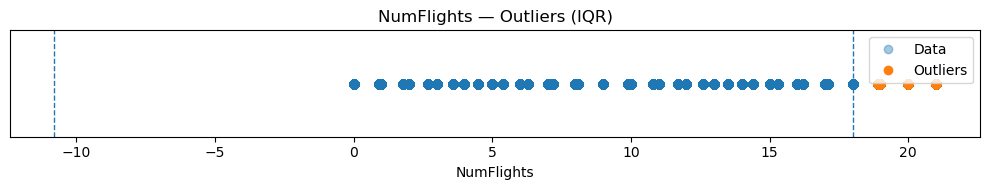

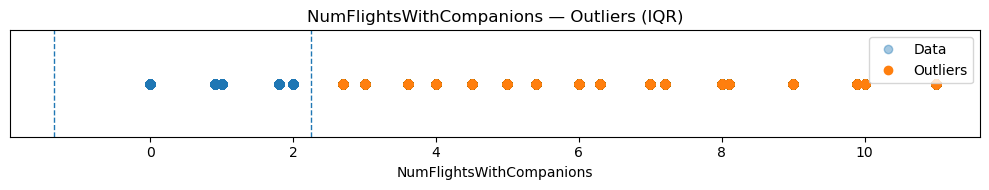

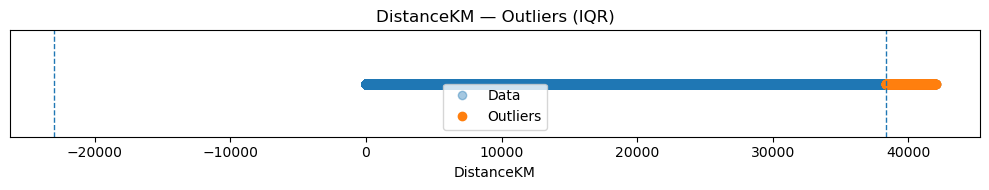

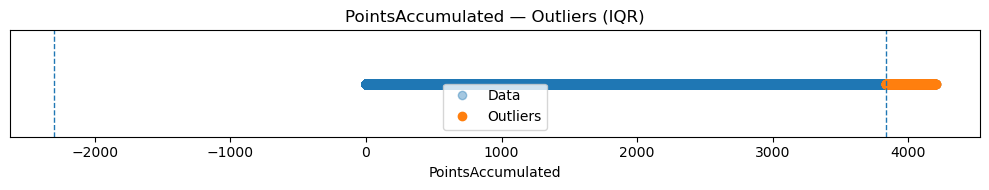

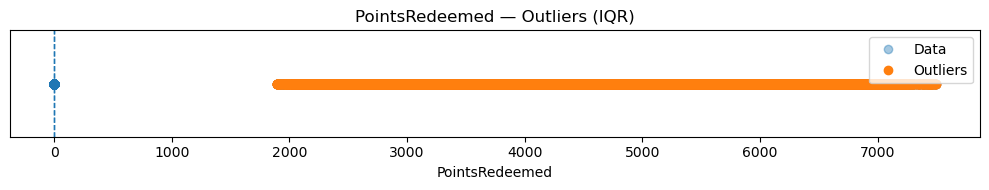

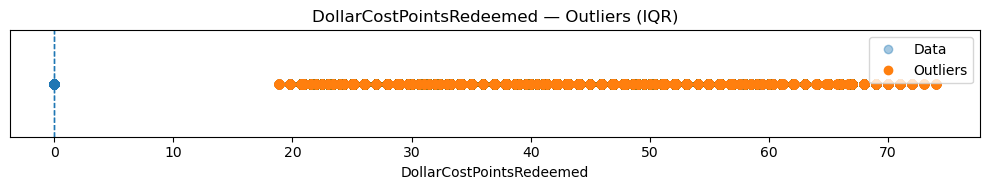

In [18]:
for feat in numeric_features:
    col_data = flights_db[feat].dropna()

    q1 = col_data.quantile(0.25)
    q3 = col_data.quantile(0.75)
    iqr = q3 - q1

    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    outliers = col_data[(col_data < lower_limit) | (col_data > upper_limit)]

    plt.figure(figsize=(10, 2))
    plt.plot(col_data, [0]*len(col_data), 'o', alpha=0.4, label='Data')
    plt.plot(outliers, [0]*len(outliers), 'o', label='Outliers')

    plt.axvline(lower_limit, linestyle='--', linewidth=1)
    plt.axvline(upper_limit, linestyle='--', linewidth=1)

    plt.title(feat + " — Outliers (IQR)")
    plt.yticks([])
    plt.xlabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()


# <a id="preprocessing"></a> Preprocessing

## <a id="missing-values"></a> Missing Values

## <a id="convert-data-types"></a> Convert data types